In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import metapack as mp
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import json

%run ./lib.py

In [2]:
import metapack as mp
pkg = mp.open_package('http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1.csv')
pkg

# Survey of Consumer Finances, Inheritance Extract
`federalreserve.gov-consumer_finances-2016-inherit-1.1.1` Last Update: 2020-10-21T04:21:11

_An Extract from the survey of consumer finances for studying networth and ineritance_


## Documentation Links

* [Documentation Page](http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1/index.html) 

 
## Images

[![doc_img](http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1/docs/networth_race_inc.png "networth_race_inc")](http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1/docs/networth_race_inc.png)

Net Worth by Income Percentile and Race
## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [inherit_scf_16](http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1/data/inherit_scf_16.csv)**. Extract of the 2016 SCF for inheritance and networth

## References
<ul><li> <strong><a href="https://www.federalreserve.gov/econres/files/scf2016s.zip#p16i6.dta">scf_public_16</a></strong>. Survey of consumer finances, full public dataset, 2016</li><li> <strong><a href="https://www.federalreserve.gov/econres/files/scfp2016s.zip#rscfp2016.dta">scf_extract_16</a></strong>. Survey of consumer finances, public extract, 2016</li><li> <strong><a href="https://www.federalreserve.gov/econres/files/scf2016rw1s.zip#p16_rw1.dta">scf_weights_16</a></strong>. Survey of consumer finances, replicate weights, 2016</li><ul>

In [3]:
# Create Dataframes
df = pkg.resource('inherit_scf_16').dataframe()

In [4]:
d = '/Users/eric/proj/data-projects/insights/survey_consumer_finances/federalreserve.gov-consumer_finances-2016-inherit/data/'
df = pd.read_csv(d+'inherit_scf_16.csv')

df.head()

#with open('categoricals.json') as f:
#    categoricals = json.load(f)
    
#for c in categoricals:
#    df[c] = df[c].astype('category')
    
df.head()

,case_id,record_id,implicate_id,age_1,age_2,hisp,race,addtional_race,unusual_income,ed_1,...,nwpctle,n_gift,n_inherit,n_trust,n_transfer,any_transfer,any_inherit,hhsize,networthpc,assetpc
0,1,11,1,71,0,5,white,5,3,assoc_vocational,...,60,0,0,0,0,0,0,1,187954.520394,188358.677918
1,1,12,2,71,0,5,white,5,3,assoc_vocational,...,60,0,0,0,0,0,0,1,188071.513361,188465.035162
2,1,13,3,71,0,5,white,5,3,assoc_vocational,...,60,0,0,0,0,0,0,1,187965.156118,188358.677918
3,1,14,4,71,0,5,white,5,3,assoc_vocational,...,60,0,0,0,0,0,0,1,187965.156118,188358.677918
4,1,15,5,71,0,5,white,5,3,assoc_vocational,...,60,0,0,0,0,0,0,1,188071.513361,188465.035162


In [5]:
# Get the extract and pull out a few more variables
#scfe = pkg.reference('scf_extract').dataframe().rename(columns={'Y1': 'record_id'})
#scfe.columns = [c.lower() for c in scfe.columns]
#df = df.merge(scfe, on='record_id', suffixes=('','_other') )


In [6]:
#dfs = make_sample(df, N=200_000, extra_cols=[
#    'occ','occ_1', 'nincpctlecat','nwpctlecat', 'racecl','debt', 'spend_exceeds', 'saved', 'lt_planner', 'homeeq', 'debt2inc',
#    'fin_risk', 'fin_know','borrow_vacation', 'spend_exceeds_excl_house'])

#dfs['hhsize'] = df.married.apply( lambda v: 1 if v ==2 else 2)
#dfs['networthpc'] = dfs.networth / dfs.hhsize
#dfs['assetpc'] = dfs.asset / dfs.hhsize

dfs = df.sample(500_000, replace=True, weights=df.wt0)

# Create quantiles for gi_sum
o, gi_sum_bins = pd.qcut(dfs[dfs.gi_sum > 0].gi_sum, 10 , retbins = True)
gi_sum_bins[0] = 0 # So zero gets included in a bin
dfs['gi_sum_decile']  = pd.cut(dfs.gi_sum, gi_sum_bins, labels=False).fillna(0)

dfs.head()

,case_id,record_id,implicate_id,age_1,age_2,hisp,race,addtional_race,unusual_income,ed_1,...,n_gift,n_inherit,n_trust,n_transfer,any_transfer,any_inherit,hhsize,networthpc,assetpc,gi_sum_decile
13045,2616,26161,1,34,34,5,white,5,3,hs,...,0,0,0,0,0,0,2,-2.087261e+04,1.067827e+05,0.0
14928,2993,29934,4,66,68,5,black,5,3,hs,...,0,0,0,0,0,0,2,5.998549e+04,9.471113e+04,0.0
14222,2851,28513,3,55,0,5,white,5,3,bachelors,...,0,1,0,1,1,1,1,1.220875e+06,1.522398e+06,2.0
6737,1351,13513,3,84,0,5,white,5,3,bachelors,...,0,0,0,0,0,0,1,7.445007e+04,7.445007e+04,0.0
9658,1936,19364,4,54,51,5,white,5,3,bachelors,...,0,0,0,0,0,0,2,1.969736e+06,1.991008e+06,0.0


family structure: 
* 1=not married/LWP + children, 
* 2=not married/LWP + no children + head under 55, 
* 3=not married/LWP + no children + head 55 or older, 
* 4=married/LWP + children
* 5=married/LWP + no children;

In [7]:
t=dfs.groupby(['occ_1','race']).norminc.count().to_frame().reset_index()
pd.crosstab(t.occ_1 ,t.race, t.norminc, aggfunc=np.sum, margins=True, normalize='index')

race,black,hisp,other,white
occ_1,,,,
0,0.171163,0.082126,0.041432,0.705279
1,0.125762,0.072373,0.067257,0.734607
2,0.193588,0.119748,0.048885,0.637780
3,0.222716,0.197794,0.038088,0.541402
4,0.084408,0.225052,0.028021,0.662519
5,0.203293,0.160776,0.035585,0.600347
6,0.054190,0.228042,0.017123,0.700645
All,0.158678,0.114582,0.047508,0.679232


In [8]:
dfs[dfs.nincpctlecat <=10].groupby('occ_1').norminc.median()

occ_1
0    37705.151694
1    89415.074018
2    58173.662614
3    43091.601936
4    62482.822808
5    54941.792469
6    53864.502421
Name: norminc, dtype: float64

In [9]:
dfs[dfs.nincpctlecat <=10].groupby(['occ','agecl']).norminc.median().unstack().T.round(0)

occ,1,2,3,4,5,6,7
agecl,,,,,,,
35-44,94802.0,63560.0,43092.0,49555.0,48478.0,36628.0,25855.0
45-54,103420.0,64637.0,43092.0,49555.0,48478.0,48478.0,22623.0
55-64,99111.0,66792.0,38782.0,64637.0,54942.0,59251.0,26932.0
65-74,96956.0,75410.0,36628.0,75410.0,45246.0,49803.0,42014.0
<35,65715.0,40937.0,36628.0,38782.0,34473.0,30164.0,19391.0
>=75,81282.0,48478.0,43576.0,48478.0,45246.0,34473.0,38782.0


In [10]:
dfs[dfs.nincpctlecat <=10].groupby(['famstruct','nincpctlecat']).networth.median().unstack().T

famstruct,1,2,3,4,5
nincpctlecat,,,,,
1,5.328498e+03,3.297075e+02,8.721294e+03,4456.368495,2.010152e+04
2,4.605269e+03,3.063089e+03,5.945370e+04,9433.887482,4.105390e+04
3,1.207261e+04,7.764079e+03,1.109306e+05,14996.371308,8.010828e+04
4,2.040995e+04,1.436886e+04,1.687039e+05,18187.088608,7.881072e+04
5,4.020304e+04,4.328740e+04,2.799642e+05,38756.579466,1.357118e+05
6,8.880830e+04,5.860284e+04,3.636354e+05,72844.075949,1.593232e+05
7,1.170089e+05,9.100989e+04,3.666134e+05,97614.677918,2.357727e+05
8,1.708097e+05,1.935702e+05,4.897751e+05,146560.281294,2.976939e+05
9,3.136475e+05,3.556320e+05,1.180034e+06,321517.946554,6.038432e+05


In [11]:
t.loc[:, t.dtypes ==  pd.core.arrays.integer.Int64Dtype].columns

Index(['race'], dtype='object')

In [12]:
t = dfs.dropna().copy()

t = t[t.nwpctlecat <=10 ]

for c in dfs.loc[:, dfs.dtypes == np.float64].columns:
    t[c] = t[c].astype(float)

for c in  t.loc[:, t.dtypes ==  pd.core.arrays.integer.Int64Dtype].columns:
    try:
        t[c] = t[c].astype(int)
    except:
        pass

# Why are these not caught by the prior conversions?
#for c in ['agecl', 'housecl', 'famstruct', 'indcat', 'edcl', 'occ', 'nwpctlecat', 'racecl']:
#    t[c] = t[c].astype(int)
 
t['debt_ihs'] = np.arcsinh(t.debt)
t['asset_ihs'] = np.arcsinh(t.asset)
t['assetpc_ihs'] = np.arcsinh(t.assetpc)
t['networth_ihs'] = np.arcsinh(t.networth)
t['networthpc_ihs'] = np.arcsinh(t.networthpc)
t['norminc_ihs'] = np.arcsinh(t.norminc)
t['gi_sum_ihs'] = np.arcsinh(t.gi_sum.astype(float))

t['nwrank'] = t.networth.rank().astype(int)
t['nincrank'] = t.norminc.rank().astype(int)
t['girank'] = t.gi_sum.rank()

regr = t # [t.networth > 0] # t[(t.agecl==3) & (t.housecl==1) & (t.famstruct==4)]



regr.to_csv('regression_set.csv')

In [13]:
m = ols('asset_ihs ~ norminc_ihs + gi_sum_ihs + C(racecl) + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) ',
        data=regr).fit()

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              asset_ihs   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                 3.835e+04
Date:                Mon, 04 Jan 2021   Prob (F-statistic):               0.00
Time:                        12:56:14   Log-Likelihood:            -8.5862e+05
No. Observations:              474740   AIC:                         1.717e+06
Df Residuals:                  474717   BIC:                         1.718e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.8225      0.040    121.293      0.000       4.745       4.900
C(racecl)[T.2]             -0.2652      0.005    -55.326      0.000      -0.275      -0.256
C(agecl)[T.45-54]           0.1825      0.007     25.287      0.000       0.168       0.197
C(agecl)[T.55-64]           0.3518      0.008     42.823      0.000       0.336       0.368
C(agecl)[T.65-74]           0.6838      0.010     70.853      0.000       0.665       0.703
C(agecl)[T.<35]            -0.0908      0.007    -12.612      0.000      -0.105      -0.077
C(agecl)[T.>=75]            0.9648      0.011     89.923      0.000       0.944       0.986
C(housecl)[T.2]            -2.5637      0.005   -489.896      0.000      -2.574      -2.553
C(famstruct)[T.2]           0.1226      0.009     14.324      0.000       0.106       0.139
C(famstruct)[T.3]          -0.0569      0.009     -6.244      0.000      -0.075      -0.039
C(famstruct)[T.4]           0.2547      0.008     33.151      0.000       0.240       0.270
C(famstruct)[T.5]           0.1421      0.008     17.770      0.000       0.126       0.158
C(edcl)[T.HS/GED]          -0.5061      0.006    -80.770      0.000      -0.518      -0.494
C(edcl)[T.No HS]           -0.9505      0.008   -115.785      0.000      -0.967      -0.934
C(edcl)[T.Some College]    -0.2989      0.006    -50.598      0.000      -0.310      -0.287
C(occ)[T.2]                -0.2123      0.007    -31.094      0.000      -0.226      -0.199
C(occ)[T.3]                -0.2179      0.008    -25.848      0.000      -0.234      -0.201
C(occ)[T.4]                -0.3100      0.010    -30.491      0.000      -0.330      -0.290
C(occ)[T.5]                -0.3554      0.011    -31.806      0.000      -0.377      -0.334
C(occ)[T.6]                 0.1607      0.027      5.873      0.000       0.107       0.214
C(occ)[T.7]                -0.6695      0.007    -91.495      0.000      -0.684      -0.655
norminc_ihs                 0.7326      0.003    230.811      0.000       0.726       0.739
gi_sum_ihs                  0.0332      0.000     66.539      0.000       0.032       0.034
==============================================================================
Omnibus:                   242346.638   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3704451.372
Skew:                          -2.098   Prob(JB):                         0.00
Kurtosis:                      16.026   Cond. No.                         225.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:

m = ols('asset_ihs ~ norminc_ihs + gi_sum_ihs + C(edcl) + C(agecl) + C(married) + C(lt_planner) + C(occat1) + C(spend_exceeds) + C(housecl)',
        data=regr).fit()

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              asset_ihs   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                 4.747e+04
Date:                Mon, 04 Jan 2021   Prob (F-statistic):               0.00
Time:                        12:56:24   Log-Likelihood:            -8.5670e+05
No. Observations:              474740   AIC:                         1.713e+06
Df Residuals:                  474721   BIC:                         1.714e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.6690      0.040    116.518      0.000       4.590       4.748
C(edcl)[T.HS/GED]          -0.5668      0.006    -94.736      0.000      -0.579      -0.555
C(edcl)[T.No HS]           -1.0482      0.008   -134.063      0.000      -1.064      -1.033
C(edcl)[T.Some College]    -0.3543      0.006    -61.986      0.000      -0.365      -0.343
C(agecl)[T.45-54]           0.1497      0.007     20.885      0.000       0.136       0.164
C(agecl)[T.55-64]           0.2437      0.007     32.767      0.000       0.229       0.258
C(agecl)[T.65-74]           0.4740      0.009     51.389      0.000       0.456       0.492
C(agecl)[T.<35]            -0.0660      0.007     -9.290      0.000      -0.080      -0.052
C(agecl)[T.>=75]            0.7360      0.010     71.635      0.000       0.716       0.756
C(married)[T.2]            -0.2373      0.005    -48.045      0.000      -0.247      -0.228
C(lt_planner)[T.1]          0.2232      0.005     48.667      0.000       0.214       0.232
C(occat1)[T.2]              0.4560      0.008     59.875      0.000       0.441       0.471
C(occat1)[T.3]             -0.2809      0.007    -39.115      0.000      -0.295      -0.267
C(occat1)[T.4]             -0.5932      0.010    -60.078      0.000      -0.613      -0.574
C(spend_exceeds)[T.2]      -0.0667      0.006    -10.866      0.000      -0.079      -0.055
C(spend_exceeds)[T.3]       0.1768      0.006     28.907      0.000       0.165       0.189
C(housecl)[T.2]            -2.5624      0.005   -493.817      0.000      -2.573      -2.552
norminc_ihs                 0.7323      0.003    233.255      0.000       0.726       0.738
gi_sum_ihs                  0.0357      0.000     72.386      0.000       0.035       0.037
==============================================================================
Omnibus:                   245235.780   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3722360.028
Skew:                          -2.134   Prob(JB):                         0.00
Kurtosis:                      16.037   Cond. No.                         227.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# 'asset_ihs ~ norminc_ihs + gi_sum_ihs + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) ',
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.quantreg('asset_ihs ~ norminc_ihs + gi_sum_ihs + C(edcl) + C(agecl) + C(married) + C(lt_planner) + C(occat1) + C(spend_exceeds) + C(housecl)',
        data=regr)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              asset_ihs   Pseudo R-squared:               0.4944
Model:                       QuantReg   Bandwidth:                     0.05099
Method:                 Least Squares   Sparsity:                        1.717
Date:                Mon, 04 Jan 2021   No. Observations:               474740
Time:                        13:16:26   Df Residuals:                   474721
                                        Df Model:                           18
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.6850      0.023    114.803      0.000       2.639       2.731
C(edcl)[T.HS/GED]          -0.3613      0.003   -103.452      0.000      -0.368      -0.354
C(edcl)[T.No HS]           -0.5739      0.005   -125.768      0.000      -0.583

In [15]:
dfs[(dfs.nincpctlecat<=9)&(dfs.spend_exceeds==3)].groupby(['occ','race']).norminc.mean().unstack()

race,black,hisp,other,white
occ,,,,
1,84730.851543,88038.475601,94346.446031,95804.997671
2,64112.907427,66474.576568,57071.813897,79116.380217
3,51010.890533,43845.395293,65802.995416,56211.376914
4,51105.484511,50503.790551,46690.638353,68021.027579
5,64840.607378,55321.434484,50116.864067,62438.184897
6,NaN,28009.541259,161593.507262,83681.675638
7,37795.262033,35361.331002,65954.791632,57003.352020


In [16]:
dfs[dfs.nincpctlecat<=10].groupby(['lt_planner','nincpctlecat']).networth.median().unstack().T

lt_planner,0,1
nincpctlecat,,
1,2871.645570,6.594149e+03
2,6753.684951,2.818573e+04
3,19144.303797,3.737394e+04
4,20708.818847,5.232776e+04
5,45095.471167,1.233744e+05
6,80618.790436,1.150573e+05
7,67005.063291,2.082794e+05
8,164428.298172,2.162562e+05
9,296141.108298,4.807347e+05


In [33]:
'asset_ihs ~ norminc_ihs + gi_sum_ihs + C(racecl) + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) '

dep_col = 'asset_ihs'
ob_cols = ['norminc_ihs', 'gi_sum_ihs', 'racecl']

t = regr.copy()
#t['racecl'] = (t.racecl-1).astype('uint8')

for c in 'agecl housecl famstruct edcl occ borrow_vacation spend_exceeds_excl_house fin_risk fin_know'.split():
    t[c] = t[c].astype('category')
    ob_cols.append(c)
    
y = t[dep_col]
X = pd.get_dummies(t[ob_cols])
X_ = sm.add_constant(X)
print(ob_cols)
display(X_.head())
m = OLS(y, X_).fit()
m.summary()

['norminc_ihs', 'gi_sum_ihs', 'racecl', 'agecl', 'housecl', 'famstruct', 'edcl', 'occ', 'borrow_vacation', 'spend_exceeds_excl_house', 'fin_risk', 'fin_know']


,const,norminc_ihs,gi_sum_ihs,racecl,agecl_35-44,agecl_45-54,agecl_55-64,agecl_65-74,agecl_<35,agecl_>=75,...,fin_know_1,fin_know_2,fin_know_3,fin_know_4,fin_know_5,fin_know_6,fin_know_7,fin_know_8,fin_know_9,fin_know_10
13045,1.0,11.626595,0.000000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
14928,1.0,11.525499,0.000000,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
14222,1.0,12.487535,10.819778,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6737,1.0,12.207951,0.000000,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
26083,1.0,10.886195,11.433882,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              asset_ihs   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                 1.901e+04
Date:                Mon, 04 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:08:25   Log-Likelihood:            -8.5313e+05
No. Observations:              474740   AIC:                         1.706e+06
Df Residuals:                  474693   BIC:                         1.707e+06
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.2870      0.012    106.209      0.000       1.263       1.311
norminc_ihs                    0.6972      0.003    219.711      0.000       0.691       0.703
gi_sum_ihs                     0.0303      0.000     61.412      0.000       0.029       0.031
racecl                        -0.2646      0.005    -55.478      0.000      -0.274      -0.255
agecl_35-44                   -0.1454      0.006    -24.878      0.000      -0.157      -0.134
agecl_45-54                    0.0483      0.006      8.514      0.000       0.037       0.059
agecl_55-64                    0.2168      0.005     41.271      0.000       0.206       0.227
agecl_65-74                    0.5638      0.006     88.115      0.000       0.551       0.576
agecl_<35                     -0.2616      0.005    -47.877      0.000      -0.272      -0.251
agecl_>=75                     0.8653      0.007    116.453      0.000       0.851       0.880
housecl_1                      1.9085      0.007    274.391      0.000       1.895       1.922
housecl_2                     -0.6215      0.006    -99.964      0.000      -0.634      -0.609
famstruct_1                    0.1751      0.006     30.299      0.000       0.164       0.186
famstruct_2                    0.2747      0.006     47.194      0.000       0.263       0.286
famstruct_3                    0.1319      0.006     21.753      0.000       0.120       0.144
famstruct_4                    0.4050      0.006     73.352      0.000       0.394       0.416
famstruct_5                    0.3005      0.005     56.241      0.000       0.290       0.311
edcl_College                   0.7045      0.006    122.783      0.000       0.693       0.716
edcl_HS/GED                    0.2702      0.005     58.389      0.000       0.261       0.279
edcl_No HS                    -0.1178      0.006    -21.057      0.000      -0.129      -0.107
edcl_Some College              0.4301      0.005     88.220      0.000       0.421       0.440
occ_1                          0.3948      0.006     62.675      0.000       0.382       0.407
occ_2                          0.1799      0.007     26.559      0.000       0.167       0.193
occ_3                          0.2050      0.008     26.926      0.000       0.190       0.220
occ_4                          0.0997      0.009     10.889      0.000       0.082       0.118
occ_5                          0.0705      0.010      7.160      0.000       0.051       0.090
occ_6                          0.5918      0.023     25.499      0.000       0.546       0.637
occ_7                         -0.2547      0.006    -40.105      0.000      -0.267      -0.242
borrow_vacation_1              0.6668      0.007     91.281      0.000       0.653       0.681
borrow_vacation_5              0.6202      

(474740, 55)

ValueError: operands could not be broadcast together with shapes (55,) (47,) 

0.9949033992196263

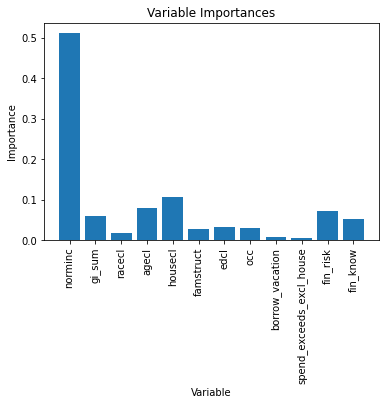

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from category_encoders import LeaveOneOutEncoder, TargetEncoder, OneHotEncoder, OrdinalEncoder, BinaryEncoder

def rf_regression(encoder=OneHotEncoder, dep_col = 'asset', df=df, x_cols=None):
    
    import warnings
    warnings.filterwarnings("ignore", message="is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead")
    
    df = df.copy()
    
    df['const'] = 1
    
    if x_cols is None:
        x_cols = [c for c in df.columns if c != dep_col]
    
    y = df[dep_col]

    enc = encoder()
    X = enc.fit_transform(df[x_cols], y)

    train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.3)

    rf = RandomForestRegressor()
    rf.fit(train_features, train_labels)

    # Set the style
    import matplotlib.pyplot as plt

    feature_list = list(X.columns)
    importances = list(rf.feature_importances_)# List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    x_values = list(range(len(importances)))# Make a bar chart
    plt.bar(x_values, importances, orientation = 'vertical')# Tick labels for x axis
    plt.xticks(x_values, feature_list, rotation='vertical')# Axis labels and title
    plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

    return rf, rf.score(test_features, test_labels), feature_importances, X, y

x_cols = 'norminc racecl agecl housecl famstruct edcl occ borrow_vacation spend_exceeds_excl_house'.split()
x_cols = [
    'norminc',
    'housecl',
    'racecl',
    'famstruct',
    'occ',
    'borrow_vacation',
    'spend_exceeds_excl_house',
    'age_1',
    'age_2',
    'ed_1',
    'ed_2',
    'fin_risk',
    'shop_credit_2',
    'fin_know',
    'gi_sum',
    'indcat',
    'debt2inc']

x_cols = [
 'norminc',
 'homeeq', 
 'debt2inc',
 'debt',
 'age_1',
 'age_2',
 'agecl',
 'fin_know',
 'gi_sum',
 'occ',
 'shop_credit', 'shop_credit_2', 
 'fin_risk',
 'edcl',
 'racecl']

x_cols = ['norminc', 'gi_sum', 'racecl', 'agecl', 'housecl', 'famstruct', 
          'edcl', 'occ', 'borrow_vacation', 'spend_exceeds_excl_house', 'fin_risk', 'fin_know']

rf, score, fi, X, y = rf_regression(x_cols=x_cols, df=regr, encoder=TargetEncoder)
score

0.5224789892799329

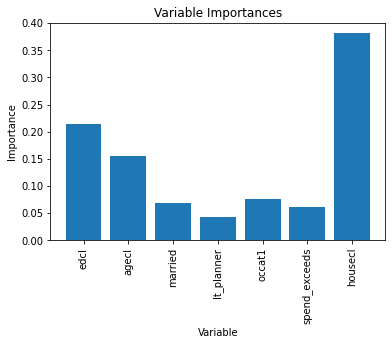

In [19]:
x_cols =  [ 'edcl','agecl', 'married','lt_planner','occat1', 'spend_exceeds', 'housecl']

rf, score, fi, X, y = rf_regression(x_cols=x_cols, df=regr, encoder=TargetEncoder)
score


0.9684543306817799

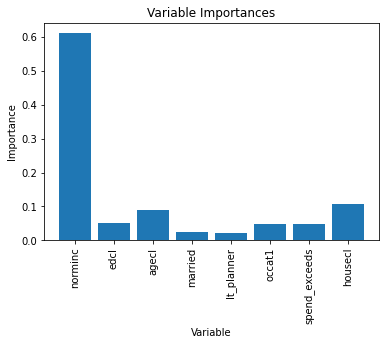

In [21]:
x_cols =  [ 'norminc', 'edcl','agecl', 'married','lt_planner','occat1', 'spend_exceeds', 'housecl']

rf, score, fi, X, y = rf_regression(x_cols=x_cols, df=regr, encoder=TargetEncoder)
score

In [22]:
dfs['normincpc'] = dfs.norminc/dfs.hhsize

0.5084849822388025

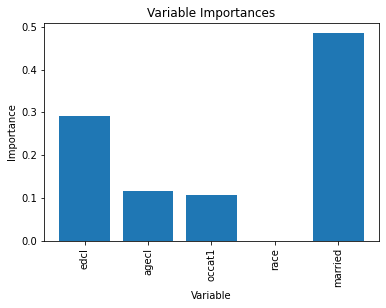

In [23]:
x_cols =  [ 'edcl','agecl', 'occat1', 'race', 'married' ]

rf, score, fi, X, y = rf_regression(x_cols=x_cols, df=regr[regr.race=='white'], dep_col='nincpctle', encoder=TargetEncoder)
score

0.8752959842674765

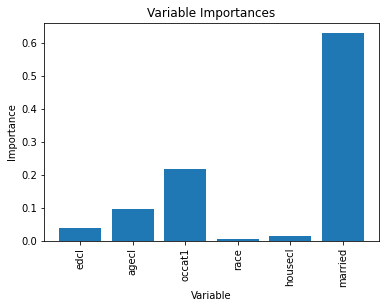

In [24]:
x_cols =  [ 'edcl',  'agecl', 'occat1', 'race',  'housecl', 'married']

rf, score, fi, X, y = rf_regression(x_cols=x_cols, df=regr, dep_col='norminc', encoder=TargetEncoder)
score

0.8441272205870812

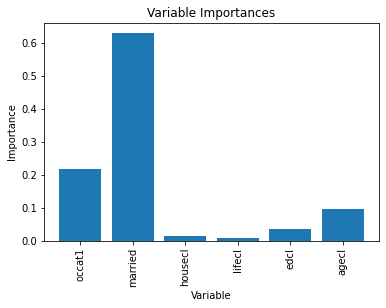

In [25]:
x_cols =  [  'occat1',  'married', 'housecl', 'lifecl', 'edcl', 'agecl']

rf, score, fi, X, y = rf_regression(x_cols=x_cols, df=regr, dep_col='norminc', encoder=TargetEncoder)
score

In [26]:
fi

[('occat1', 0.22),
 ('married', 0.63),
 ('housecl', 0.01),
 ('lifecl', 0.01),
 ('edcl', 0.04),
 ('agecl', 0.1)]

In [27]:
x_cols =  [ 'edcl','agecl', 'occat1', 'race',  'housecl', 'married', 'lifecl' ]
enc = TargetEncoder(cols=x_cols)
y = regr['norminc']
X = enc.fit_transform(regr[x_cols], y)
X.describe().sort_values('std',axis=1)
    

,agecl,race,occat1,married,housecl,lifecl,edcl
count,474740.000000,474740.000000,474740.000000,474740.000000,474740.000000,474740.000000,474740.000000
mean,78462.217966,78462.217966,78462.217966,78462.217966,78462.217966,78462.217966,78462.217966
std,13364.787598,13486.681875,19490.276794,22282.070146,23129.815769,26256.496082,32093.489370
min,59582.328076,55467.124739,42933.996996,53713.908632,48864.322459,48222.406382,38747.512232
25%,65064.694656,58587.354886,52720.341736,53713.908632,48864.322459,53741.805616,56861.257810
50%,82193.507403,86537.219243,90828.223800,98523.774393,96537.396672,91388.846062,66621.733467
75%,92772.883705,86537.219243,90828.223800,98523.774393,96537.396672,106370.046255,124123.380578
max,93182.624758,92675.305601,99044.967587,98523.774393,96537.396672,107263.275519,124123.380578


In [ ]:
from sklearn.linear_model import ElasticNetCV

r = ElasticNetCV(cv=5, random_state=0)


r.fit(X, y)

print(r.alpha_)

print(r.intercept_)

r.score(X, y)

In [ ]:
dfs.groupby(['married']).normincpc.mean()

# Quantile Regression


In [28]:

x_cols =  [ 'edcl','agecl', 'occat1', 'race',  'housecl', 'married', 'lifecl' ]

enc = TargetEncoder(cols=x_cols)
y = regr['norminc']
X = enc.fit_transform(regr, y)
X

,case_id,record_id,implicate_id,age_1,age_2,hisp,race,addtional_race,unusual_income,ed_1,...,debt_ihs,asset_ihs,assetpc_ihs,networth_ihs,networthpc_ihs,norminc_ihs,gi_sum_ihs,nwrank,nincrank,girank
13045,2616,26161,1,34,34,5,86537.219243,5,3,hs,...,13.143383,12.964845,12.271698,-11.332487,-10.639340,11.626595,0.000000,13320,241285,192674.5
14928,2993,29934,4,66,68,5,58587.354886,5,3,hs,...,11.841528,12.844881,12.151734,12.388152,11.695005,11.525499,0.000000,264969,216543,192674.5
14222,2851,28513,3,55,0,5,86537.219243,5,3,bachelors,...,13.309748,14.928944,14.928944,14.708225,14.708225,12.487535,10.819778,448503,410771,415622.5
6737,1351,13513,3,84,0,5,86537.219243,5,3,bachelors,...,0.000000,11.911031,11.911031,11.911031,11.911031,12.207951,0.000000,222917,363777,192674.5
26083,5228,52284,4,82,81,5,86537.219243,5,3,assoc_vocational,...,0.000000,13.607433,12.914286,13.607433,12.914286,10.886195,11.433882,377429,93857,428205.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,258,2584,4,87,0,5,86537.219243,5,3,hs,...,0.000000,12.035900,12.035900,12.035900,12.035900,10.073246,0.000000,231738,20223,192674.5
1484,299,2995,5,49,51,5,86537.219243,5,2,some_college,...,12.428974,12.995013,12.301866,12.156216,11.463069,11.752889,0.000000,242808,264851,192674.5
892,181,1813,3,65,0,5,86537.219243,5,3,bachelors,...,12.019245,13.504920,13.504920,13.248285,13.248285,12.118002,0.000000,345069,345699,192674.5
26728,5357,53574,4,54,50,5,86537.219243,5,3,masters,...,13.627143,14.734364,14.041217,14.333175,13.640028,12.775218,0.000000,428475,438934,192674.5


In [32]:
# 'asset_ihs ~ norminc_ihs + gi_sum_ihs + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) ',
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.quantreg('asset ~ norminc + gi_sum + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) ', df)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  asset   Pseudo R-squared:               0.3295
Model:                       QuantReg   Bandwidth:                   6.185e+04
Method:                 Least Squares   Sparsity:                    8.283e+05
Date:                Mon, 04 Jan 2021   No. Observations:                31240
Time:                        13:06:41   Df Residuals:                    31218
                                        Df Model:                           21
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -8.122e+04   3167.495    -25.642      0.000   -8.74e+04    -7.5e+04
C(agecl)[T.45-54]       -7287.5849   5997.488     -1.215      0.224    -1.9e+04    4467.731
C(agecl)[T.55-64]        -1.85e+04   4827.969     -3.832      0.000    -2.8e+04

/Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


# Blinder-Oaxaca Decomposition

# Other Relationships

In [ ]:
dfs[['asset','debt','networth']].corr()

In [ ]:
dfs['homeeq_gtz'] = dfs.homeeq > 0
df['homeeq_gtz'] = df.homeeq > 0
dfs.groupby(['race']).homeeq_gtz.mean()

In [ ]:
dfs[dfs.homeeq_gtz].groupby(['race']).homeeq.mean()

In [ ]:
df[df.homeeq_gtz].groupby(['famstruct']).case_id.count()

In [ ]:
dfs.groupby(['race', dfs.networth > 0]).lt_planner.mean().unstack()

In [ ]:
# Races dont differ in debts
dfs.groupby(['race', dfs.gi_sum > 0]).debt.mean().unstack()

In [ ]:
# Races dont differ in debts
dfs.groupby(['race', dfs.gi_sum > 0]).debt.mean().unstack()

In [ ]:
dfs.groupby(['nincpctlecat']).saved.mean()

In [ ]:
# Saving distinguishes people with positive networths from negative networths most 
# in the middle incomes, and is not as predictive for the poorest and richest. 
t = dfs.groupby(['nincpctlecat', dfs.networth > 0]).saved.mean().unstack()
t = t[True] - t[False]
t.plot()


In [ ]:
dfs.debt2inc.describe()

In [ ]:
# Transfers have maybe 10% effect on debt
dfs.groupby([dfs.gi_sum > 0]).debt.mean()

In [ ]:
# Families that have recieved transfers have assets twice as large
t = dfs[dfs.age_1 < 45].copy()
t = t.groupby(['race',t.gi_sum > 0]).asset.median().unstack()
t['diff'] = t[True] - t[False]
t

In [ ]:
# But the also have larger incomes
t = dfs[dfs.age_1 < 45].copy()
t = t.groupby(['race',t.gi_sum > 0]).norminc.median().unstack()
t['diff'] = t[True] - t[False]
t

In [ ]:
# Whites and blacks hold similar amounts of debt, and debt to income, 
# across income ranges. 
dfs.groupby(['nincpctlecat', 'race']).mean()[['debt','debt2inc']].unstack()

In [ ]:
t = dfs[
    (dfs.age_1 < 50) & (dfs.age_1 > 40 ) & (dfs.homeeq > 0) 
]

t = t.groupby(['race','nincpctlecat']).asset.mean().unstack().T
t.columns = list(t.columns)
t['r'] = t.black / t.white

t

# White / Black Prediction


In [ ]:
t = regr[(regr.race=='white') & (regr.nincpctle < 90)]

m = ols('asset_ihs ~ norminc_ihs + gi_sum_ihs + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) ',
        data=t)

r = m.fit()

r.summary()

In [ ]:
t = regr[regr.race=='white']
p = np.sinh(r.predict(t))

def rmse(a, b):
    return np.sqrt(np.mean(np.square(a-b)))
    
rmse(p,t.asset)

In [ ]:
p.describe()

In [ ]:
(p - t.asset).hist(bins=100)

In [ ]:
rmse(t.asset,t.asset-( (np.random.standard_normal(len(t)))*10000))

In [ ]:
e = pd.Series((np.random.standard_normal(len(t))*10000))
e

In [ ]:
rmse(0,e)

In [ ]:
t = pd.DataFrame({
    'const': 1,
    'a':np.random.standard_normal(1000)*10, 
    'b':np.random.standard_normal(1000)*10, 
    'c': np.random.random(1000)*10, 
    'd': np.random.randint(0,10, 1000), 
    'e': np.random.random(1000)*10, 
    
    'err': 0
    
})

d_map = { i:np.random.normal(150, 100) for i in range(10) }


rnd = (np.random.standard_normal(1000)/2) + 1

t['o'] = 5*t.a + 7*t.b + 13*t.c + t.d.map(d_map) +   100 

#t['err'] = np.random.standard_normal(1000)* (t.o/5)
#t['o'] = t.o + t.err

m = ols('o ~ a + b + c', data=t)

r = m.fit()

r.summary()


In [ ]:
np.random.randint(0,10)

In [ ]:
t.d.map(d_map)